In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import time
import csv
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from math import ceil
import utils
import augment
import model
import keras.models as md
import sklearn
import numpy as np

Using TensorFlow backend.


# Load the training data

Training data contains total 8 laps for each track <br> 
4 laps each in opposite direction <br> 
while 2 laps are mostly driving at the center , the other 2 laps contains <br>
data to correct to center if dragged to each of the sides. <br>

In [3]:
cols = {0: 'Center Image', 1: 'Left Image', 2: 'Right Image', 3: 'Steering Angle', 4: 'Throttle', 5:'Break', 6:'Speed'}
track1_df = utils.read_csv_and_rename_cols('train_hd/driving_log.csv', columns=cols)
track1_df.head()

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed
0,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,0.0,1.0,0.0,30.19074
1,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,0.0,1.0,0.0,30.18880
2,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,0.0,1.0,0.0,30.18910
3,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,0.0,1.0,0.0,30.18921
4,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,/AI_DEVa/autonomous_car_nd/CarND-Behavioral-Cl...,0.0,1.0,0.0,30.18993


In [4]:
track1_df.shape

(12208, 7)

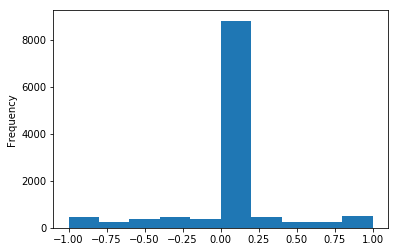

In [5]:
plt.figure()
track1_df['Steering Angle'].plot.hist()

As can be seen in above histogram, steering angles are concentrated around 0- 0.25 degree.<br>
There seems a bit imbalance to the left of 0<br>
We'll use some data augmentation to partly overcome this imbalance <br>

# Data Augmentation

We'll do following augmentations <br>
1) We'll randomly flip some images to keep balance of left turn and right turn <br>
2) We'll randomly adjust brightness of some pics <br>
3) We'll add some random horizontal and vertical shift and adjust the steering angle accordingly. <br>
4) We'll add some random shadow on left or right side of the image randomly<br>
<br>
<br>
We'll use all 3 images from each of the left, center and right camera.<br>
We have only steering angle for center image, we'll adjust the steering angle for left_image by adding some adjustment <br>
Similarely we'll adjust steering angle for right_image by subtracting adjustment<br>

In [6]:
def augment_img(img, steering):
    img, steering = augment.flip(img, steering)
    img, steering = augment.random_shift(img, steering)
    img = augment.random_shadow(img)
    img = augment.adjust_brightness(img)
    return img, steering

# Preprocess

After Augmenting image we'll crop and resize image.<br>
We'll use the image size used in <br>
https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf <br>
which is 66 * 200 * 3 in YUV. <br>

In [7]:
def get_train_test_labels(df, left_correction= 0.0, right_correction = 0.0):
    images = []
    steering_angle_list = []
    for index, row in df.iterrows():
        left_img = utils.get_relative_path(row['Left Image'])
        right_img = utils.get_relative_path(row['Right Image'])
        center_img = utils.get_relative_path(row['Center Image'])
        angle = float(row['Steering Angle'])
        
        # Adjust the left and right steering angle
        langle = angle + left_correction
        rangle = angle - right_correction
        
        # Read Image
        limg = utils.read_img(left_img)
        cimg = utils.read_img(center_img)
        rimg = utils.read_img(right_img)
        
        # Augment the Image
        limg, langle = augment_img(limg, langle)
        cimg, angle = augment_img(cimg, angle)
        rimg, rangle = augment_img(rimg, rangle)
        
        # Preprocess the augmented images to feed to model
        limg = utils.preprocess(limg)
        cimg = utils.preprocess(cimg)
        rimg = utils.preprocess(rimg)
        
        images.append(limg)
        steering_angle_list.append(langle)
        images.append(cimg)
        steering_angle_list.append(angle)
        images.append(rimg)
        steering_angle_list.append(rangle)
        
    return images, steering_angle_list

In [8]:
def generator(df, bs=32):
    total = len(df)
    while 1:
        sklearn.utils.shuffle(df)
        for offset in range(0, total, bs):
            batch = df[offset:offset+bs]
            images, angles = get_train_test_labels(batch, 0.2, 0.2)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [9]:
train_samples, valid_samples = train_test_split(track1_df, test_size=0.2)

In [10]:
train_generator = generator(train_samples)
valid_generator = generator(valid_samples)

# Display Images and Steering angle

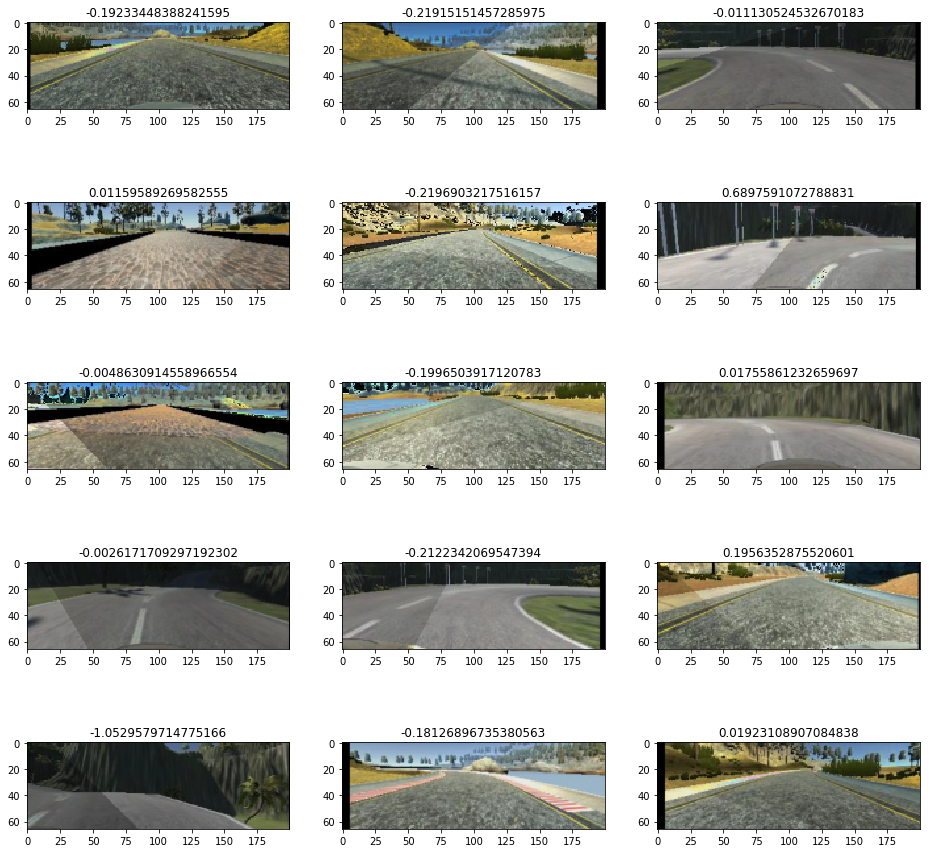

In [11]:
next_batch = []

for batch in train_generator:
    next_batch = batch
    break

utils.display_multiple_images(next_batch[0][:15], next_batch[1][:15])

# Model

In [12]:
optimizer=Adam(1e-4, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model = model.get_model(optimizer)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)
cp = ModelCheckpoint('model_best_fit.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [15]:
history = model.fit_generator(train_generator, 
                    steps_per_epoch= ceil(len(train_samples)/32),
                    validation_data=valid_generator, 
                    validation_steps= ceil(len(valid_samples)/32),
                    epochs=60, callbacks=[es, cp])

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
306/306 [==============================] - 466s 2s/step - loss: 0.1171 - val_loss: 0.1081

Epoch 00001: val_loss improved from inf to 0.10810, saving model to model_best_fit.h5
Epoch 2/60
306/306 [==============================] - 169s 552ms/step - loss: 0.1040 - val_loss: 0.1012

Epoch 00002: val_loss improved from 0.10810 to 0.10120, saving model to model_best_fit.h5
Epoch 3/60
306/306 [==============================] - 157s 513ms/step - loss: 0.0999 - val_loss: 0.0984

Epoch 00003: val_loss improved from 0.10120 to 0.09838, saving model to model_best_fit.h5
Epoch 4/60
306/306 [==============================] - 162s 528ms/step - loss: 0.0975 - val_loss: 0.0970

Epoch 00004: val_loss improved from 0.09838 to 0.09702, saving model to model_best_fit.h5
Epoch 5/60
306/306 [==============================] - 246s 803ms/step - loss: 0.0960 - val_loss: 0.0952

Epoch 00005: val_loss improved from 0.09702 to 0.09521, saving model to mo


Epoch 00045: val_loss did not improve from 0.07407
Epoch 46/60
306/306 [==============================] - 164s 535ms/step - loss: 0.0725 - val_loss: 0.0754

Epoch 00046: val_loss did not improve from 0.07407
Epoch 47/60
306/306 [==============================] - 163s 534ms/step - loss: 0.0728 - val_loss: 0.0749

Epoch 00047: val_loss did not improve from 0.07407
Epoch 48/60
306/306 [==============================] - 177s 577ms/step - loss: 0.0718 - val_loss: 0.0736

Epoch 00048: val_loss improved from 0.07407 to 0.07363, saving model to model_best_fit.h5
Epoch 49/60
306/306 [==============================] - 167s 547ms/step - loss: 0.0719 - val_loss: 0.0740

Epoch 00049: val_loss did not improve from 0.07363
Epoch 50/60
306/306 [==============================] - 170s 557ms/step - loss: 0.0717 - val_loss: 0.0749

Epoch 00050: val_loss did not improve from 0.07363
Epoch 51/60
306/306 [==============================] - 167s 547ms/step - loss: 0.0717 - val_loss: 0.0743

Epoch 00051: val_l

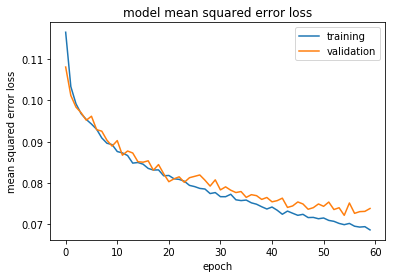

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Salient Features